## Load libraries and helper functions

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

## Poincaré Disk vs. Hyperboloid Model

In [26]:
eps = 1e-6

# distance in poincare disk
def poincare_dist(u, v, eps=1e-5):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)

# compute symmetric poincare distance matrix
def poincare_distances(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = poincare_dist(embedding[i], embedding[j])
    return dist_matrix

# convert array from poincare disk to hyperboloid
def poincare_pts_to_hyperboloid(Y):
    mink_pts = np.zeros((Y.shape[0], Y.shape[1]+1))
    r = norm(Y, axis=1)
    mink_pts[:, 0] = 2/(1 - r**2 + eps) * Y[:, 0]
    mink_pts[:, 1] = 2/(1 - r**2 + eps) * Y[:, 1]
    mink_pts[:, 2] = 2/(1 - r**2 + eps) * (1 + r**2)/2
    return mink_pts

# convert single point to hyperboloid
def poincare_pt_to_hyperboloid(y):
    mink_pt = np.zeros((3, ))
    r = norm(y)
    mink_pt[0] = 2/(1 - r**2 + eps) * y[0]
    mink_pt[1] = 2/(1 - r**2 + eps) * y[1]
    mink_pt[2] = 2/(1 - r**2 + eps) * (1 + r**2)/2
    return mink_pt

In [27]:
# define hyperboloid bilinear form
def minkowski_dot(u, v):
    return u[0]*v[0] - np.dot(u[1:], v[1:]) 

# hyperboloid distance function
def hyperboloid_dist(u, v):
    dist = np.arccosh(-1*minkowski_dot(u, v))
    if np.isnan(dist):
        #print('Hyperboloid dist returned nan value')
        return eps
    else:
        return dist

# compute symmetric hyperboloid distance matrix
def hyperboloid_distances(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = hyperboloid_dist(embedding[i], embedding[j])
    return dist_matrix

# convert array to poincare disk
def hyperboloid_pts_to_poincare(X):
    poincare_pts = np.zeros((X.shape[0], X.shape[1]-1))
    poincare_pts[:, 0] = X[:, 0] / ((X[:, 2]+1) + eps)
    poincare_pts[:, 1] = X[:, 1] / ((X[:, 2]+1) + eps)
    return poincare_pts

def proj(theta,eps=1e-3):
    if norm(theta) >= 1:
        theta = theta/norm(theta) - eps
    return theta

# convert single point to poincare
def hyperboloid_pt_to_poincare(x):
    poincare_pt = np.zeros((2, ))
    poincare_pt[0] = x[0] / ((x[2]+1) + eps)
    poincare_pt[1] = x[1] / ((x[2]+1) + eps)
    return proj(poincare_pt)

In [28]:
# helper function to generate samples
def generate_data(n, radius=0.7, hyper=False):
    theta = np.random.uniform(0, 2*np.pi, n)
    u = np.random.uniform(0, radius, n)
    r = np.sqrt(u)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    init_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
    if hyper:
        return poincare_pts_to_hyperboloid(init_data)
    else:
        return init_data

In [29]:
# test hyperboloid bilinear form condition
data = generate_data(20)
poinc_pts = data
mink_pts = poincare_pts_to_hyperboloid(data)
np.array([np.allclose(minkowski_dot(pt, pt), -1) for pt in mink_pts]).all()

# test poincare -> hyperboloid are inverses
mink_pts = poincare_pts_to_hyperboloid(data)
poinc_pts = hyperboloid_pts_to_poincare(mink_pts)
if np.allclose(data, poinc_pts):
    print('Inverse test passed!')

False

Inverse test passed!


## Gradient descent

$$
\begin{array}{c}{\text { minimize }_{w \in \mathbb{R}^{n+1}}-\frac{1}{2} w * w+C \sum_{j=1}^{m} \max \left(0, \sinh ^{-1}(1)-\sinh ^{-1}\left(y^{(j)}\left(w * x^{(j)}\right)\right)\right)} \\ {\text { subject to } w * w<0}\end{array}
$$

Projected gradient descent: project $y$ onto set $X$:<br>
$$
\Pi_{X}(y)=\underset{x \in X}{\operatorname{argmin}} \frac{1}{2}\|x-y\|_{2}^{2}
$$

In [33]:
# define hyperboloid bilinear form
def minkowski_dot(u, v):
    return u[0]*v[0] - np.dot(u[1:], v[1:])

In [34]:
def loss_fn(w, X, y, C=1.0):
    margin_loss = -1/2 * minkowski_dot(w, w)
    misclass_loss = np.arcsinh(1) - np.arcsinh(y *[minkowski_dot(w, x) for x in X])
    return margin_loss + C*np.sum(np.where(misclass_loss > 0, misclass_loss, 0))

def grad_fn(w, X, y, C=1.0):
#    if len(y.shape) < 2:
#        y = y.reshape(-1, 1)
    grad_w = w.copy()
    grad_margin = np.hstack((-w[0], w[1:]))
    misclass = np.arcsinh(1) - np.arcsinh(y*np.array([minkowski_dot(w, x) for x in X])) > 0
    f = -1/np.sqrt((y*np.array([minkowski_dot(w, x) for x in X]))**2 + 1)
    g = y.reshape(-1,1) * X
    grad_misclass = np.sum(misclass.reshape(-1,1)*f.reshape(-1,1)*g, axis=0)
    grad_w = grad_margin + C*grad_misclass
    return grad_w

In [35]:
def is_feasible(w):
    norm_cond = minkowski_dot(w, w) < 0
    return norm_cond
is_feasible(w)
is_feasible(np.array([1, 1, 1]))

False

True

In [36]:
import scipy as sp
def proj_boundary(w, alpha, eps=1e-4):
    proj_w = w.copy()
    proj_w[1:] = (1 + alpha)*proj_w[1:]
    proj_w[0] = np.sqrt(np.sum(proj_w[1:]**2 - eps))
    return proj_w

def alpha_search(w):
    #w0 = w[0]**2
    #w1 = np.sum(w[1:]**2)
    res = sp.optimize.minimize_scalar(lambda alpha: np.sum((proj_boundary(w, alpha) - w)**2))
    alpha = res.x
    return alpha

In [107]:
def proj_w(w, eps=1e-4):
    proj_w = w.copy()
    res = sp.optimize.minimize_scalar(lambda alpha: proj_fn(w, alpha))
    alpha = res.x
    proj_w[1:] = (1 + alpha) * proj_w[1:]
    proj_w[0] = np.sqrt(np.sum(proj_w[1:])**2 - eps)
    return proj_w 

In [30]:
def loss_fn(w, X, y, C=1.0):
    margin_loss = -1/2 * minkowski_dot(w, w)
    misclass_loss = np.arcsinh(1) - np.arcsinh(y *[minkowski_dot(w, x) for x in X])
    return margin_loss + C*np.sum(np.where(misclass_loss > 0, misclass_loss, 0))

def grad_fn(w, X, y, C=1.0):
#    if len(y.shape) < 2:
#        y = y.reshape(-1, 1)
    grad_w = w.copy()
    grad_margin = np.hstack((-w[0], w[1:]))
    misclass = np.arcsinh(1) - np.arcsinh(y*np.array([minkowski_dot(w, x) for x in X])) > 0
    f = -1/np.sqrt((y*np.array([minkowski_dot(w, x) for x in X]))**2 + 1)
    g = y.reshape(-1,1) * X
    grad_misclass = np.sum(misclass.reshape(-1,1)*f.reshape(-1,1)*g, axis=0)
    grad_w = grad_margin + C*grad_misclass
    return grad_w

In [31]:
X = generate_data(10)
w = np.array([1.5, 1.5])
y = np.repeat(-1, 10)
loss_fn(w, X, y, 1.0)
grad_fn(w, X, y, 1)

10.44327981894236

array([-0.8932192 ,  0.76302978])

In [22]:
def is_feasible(w):
    norm_cond = minkowski_dot(w, w) < 0
    return norm_cond
is_feasible(w)
is_feasible(np.array([1, 1, 1]))

False

True

In [23]:
import scipy as sp
def proj_boundary(w, alpha, eps=1e-4):
    proj_w = w.copy()
    proj_w[1:] = (1 + alpha)*proj_w[1:]
    proj_w[0] = np.sqrt(np.sum(proj_w[1:]**2 - eps))
    return proj_w

def alpha_search(w, alpha, eps=1e-4):
    #w0 = w[0]**2
    #w1 = np.sum(w[1:]**2)
    res = sp.optimize.minimize_scalar(lambda alpha: np.sum((proj_boundary(w, alpha, eps) - w)**2))
    alpha = res.x
    return alpha

In [24]:
def proj_w(w, eps=1e-4):
    proj_w = w.copy()
    res = sp.optimize.minimize_scalar(lambda alpha: proj_fn(w, alpha))
    alpha = res.x
    proj_w[1:] = (1 + alpha) * proj_w[1:]
    proj_w[0] = np.sqrt(np.sum(proj_w[1:])**2 - eps)
    return proj_w 

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)
#logger = logging.getLogger(__name__)
def train_hsvm(init_w, X, y, C, num_epochs, lr, batch_size, early_stopping, verbose):
    w = init_w
    num_samples = len(y)
    early_stop_count = 0
    min_loss = np.inf
    y = 2*y - 1
    if is_feasible(w):
        for j in range(num_epochs):
            start = time.time()
            current_loss = 0
            shuffle_index = np.random.permutation(num_samples)
            for i in range(0, num_samples, batch_size):
                Xj = X[shuffle_index[i:i+batch_size]]
                yj = y[shuffle_index[i:i+batch_size]]
                grad_w = grad_fn(w, Xj, yj, C)
                w = w - lr*grad_w
                # if not in feasible region, need to use projection
                if not is_feasible(w):
                    # solve optimization problem for nearest feasible point
                    alpha_opt = alpha_search(w)
                    # project w to feasible sub-space
                    w = proj_boundary(w, alpha_opt)
                current_loss += loss_fn(w, Xj, yj, C)
            current_loss = current_loss / num_samples
            if current_loss < min_loss:
                min_loss = current_loss
            else:
                early_stop_count += 1
                if early_stop_count >= early_stopping:
                    print('Exiting early: no decrease for ' + str(early_stopping) + ' rounds')
                    break
            if verbose:
                #logger.debug('loss {}'.format(sum_loss))
                print('COMPLETED EPOCH ', j+1)
                print('-------- LOSS: ', current_loss)
                #print('---------- total seconds: ', time.time() - start)
    else:
        print('Error: unable to begin training with initial w (weights)')
    return w

In [1]:
from sklearn.svm import LinearSVC

class LinearHSVM():
    """
    Hyperbolic support vector classification model trained in the hyperboloid (Lorentz) model 
    with an iterative, projected gradient descent method
    
    """
    
    def __init__(self, C=1.0, num_epochs=50, lr=0.001, tol=1e-8, batch_size=20, 
                 early_stopping=10, verbose=False):
        self.C = C
        self.num_epochs = num_epochs
        self.tol = tol
        self.verbose = verbose
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.lr = lr
        
    def init_weights(self, X, y):
        """
        Initialize w (weights) with the coefficients found from applying
        standard LinearSVC in the ambient Euclidean space
        
        """
        # fit linear svm using scikit-learn classifier
        linear_svm = LinearSVC()
        linear_svm.fit(X, y)
        self.init_coef = linear_svm.coef_[0]
    
    def fit(self, X, y):
        """
        Train linear HSVM model for input data X, labels y
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples, 1)
        """
        self.init_weights(X, y)
        self.coef_ = train_hsvm(self.init_coef, X, y, self.C, 
                                self.num_epochs, self.lr, self.batch_size,
                                self.early_stopping, self.verbose)
        return self

    def predict(self, X):
        """
        Predict class labels with hyperbolic linear decision function
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        """
        y_pred = np.zeros((X.shape[0], ))
        vals = np.array([minkowski_dot(self.coef_, x) for x in X])
        y_pred[vals < 0] = -1
        y_pred[vals >= 0] = 1
        return y_pred
    
    def score(self, X, y):
        """
        Return mean accuracy evaluated on X, y
        """
        y_pred = self.predict(X)
        return np.sum((y_pred * y) > 0) / len(y)
    
#    def decision_function(self, X):
#        """
#        This function is used for ROC AUC
#        """
#        preds = htools.mink_prod(X, self.coef_).ravel()
#        return preds
    

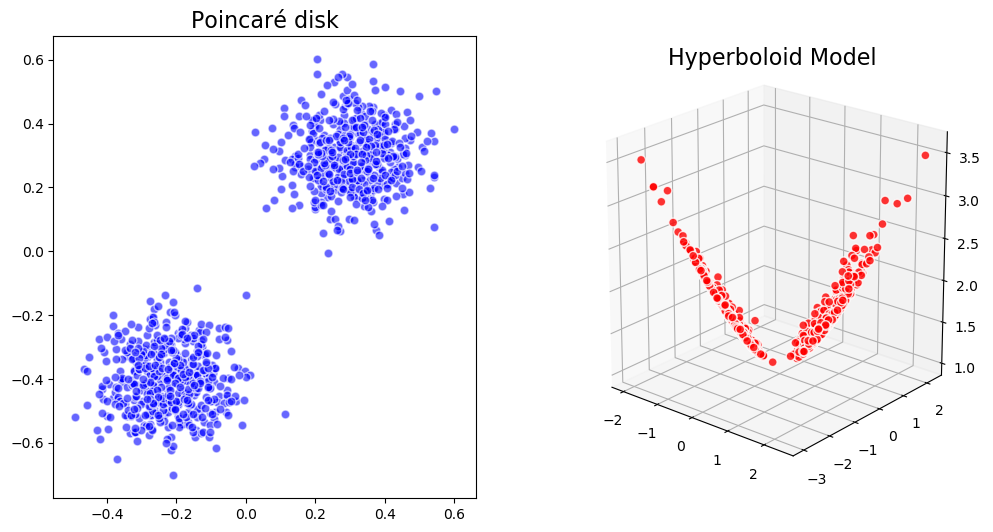

In [32]:
from sklearn.datasets import make_blobs
plt.style.use('default')
centers = [[0.3, 0.3], [-0.23, -0.4]]
X, labels = make_blobs(n_samples=1000, centers=centers, cluster_std=0.1)
data = X
mink_pts = poincare_pts_to_hyperboloid(data)
x = data[:, 0]
y = data[:, 1]

hyp_data = poincare_pts_to_hyperboloid(data)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.set_title('Poincaré disk', size=16)
ax.scatter(x, y, s=40, c='blue', edgecolor='white', linewidth=1, alpha=0.6);

ax = fig.add_subplot(122, projection = '3d')
ax.scatter(mink_pts[:, 0], mink_pts[:, 1], mink_pts[:, 2], c='red', 
           alpha=0.8, s=40, edgecolor='white', linewidth=1)
ax.set_title('Hyperboloid Model', size=16);
ax.view_init(20, -50);
plt.show();

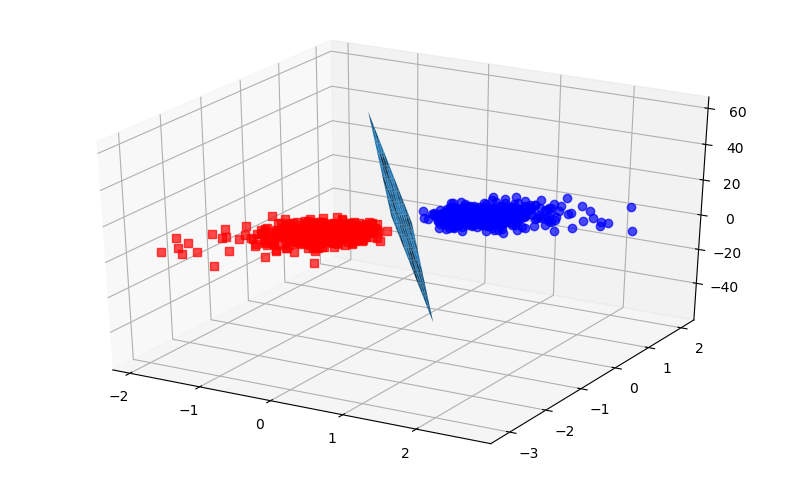

In [21]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(mink_pts, labels)
svc.coef_
z = lambda x,y: (-svc.intercept_[0]-svc.coef_[0][0]*x-svc.coef_[0][1]*y) / svc.coef_[0][2]
tmp = np.linspace(-.3,.3,10)
x,y = np.meshgrid(tmp,tmp)

# plot
fig = plt.figure(figsize=(10,6))
ax  = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z(x,y))
X = mink_pts
ax.plot3D(X[labels==0,0], X[labels==0,1], X[labels==0,2],'ob', alpha=0.7)
ax.plot3D(X[labels==1,0], X[labels==1,1], X[labels==1,2],'sr', alpha=0.7)
plt.show();

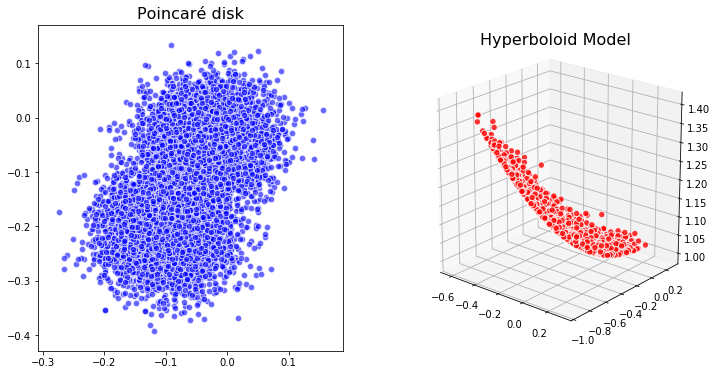

In [491]:
from sklearn.datasets import make_blobs
plt.style.use('default')
%matplotlib inline
centers = [[-0.03,-0.04], [-0.1, -0.21]]
X, labels = make_blobs(n_samples=10000, centers=centers, cluster_std=0.05)
data = X
mink_pts = poincare_pts_to_hyperboloid(data)
x = data[:, 0]
y = data[:, 1]

hyp_data = poincare_pts_to_hyperboloid(data)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.set_title('Poincaré disk', size=16)
ax.scatter(x, y, s=40, c='blue', edgecolor='white', linewidth=1, alpha=0.6);

ax = fig.add_subplot(122, projection = '3d')
ax.scatter(mink_pts[:, 0], mink_pts[:, 1], mink_pts[:, 2], c='red', 
           alpha=0.8, s=40, edgecolor='white', linewidth=1)
ax.set_title('Hyperboloid Model', size=16);
ax.view_init(20, -50);
plt.show();

COMPLETED EPOCH  1
-------- LOSS:  1.475085965741001
COMPLETED EPOCH  2
-------- LOSS:  1.4551048114123868
COMPLETED EPOCH  3
-------- LOSS:  1.4352677000201615
COMPLETED EPOCH  4
-------- LOSS:  1.4155720302836756
COMPLETED EPOCH  5
-------- LOSS:  1.3960160376596635
COMPLETED EPOCH  6
-------- LOSS:  1.3765970837427866
COMPLETED EPOCH  7
-------- LOSS:  1.357314162978787
COMPLETED EPOCH  8
-------- LOSS:  1.338164474889309
COMPLETED EPOCH  9
-------- LOSS:  1.3191470364485376
COMPLETED EPOCH  10
-------- LOSS:  1.3002600041658792


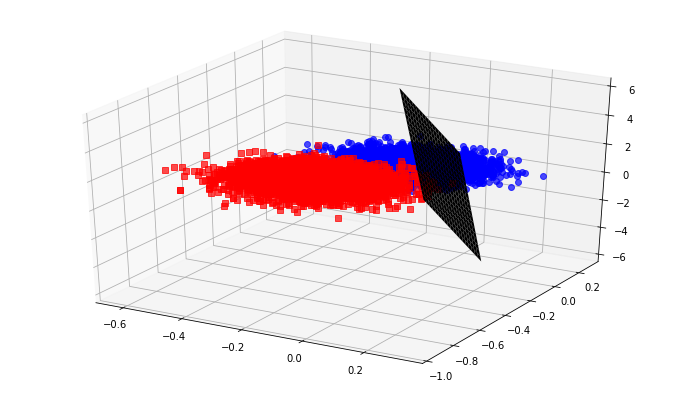

In [497]:
from sklearn.svm import LinearSVC
hsvm_clf = LinearHSVM(early_stopping=1, C=0.01, num_epochs=10, lr=0.00001, verbose=True)
hsvm_clf.fit(mink_pts, 2*labels-1)
hsvm_clf.coef_
plt.style.use('default')
z = lambda x,y: (-hsvm_clf.coef_[0]*x-hsvm_clf.coef_[1]*y) / hsvm_clf.coef_[2]
tmp = np.linspace(-.1,.1,20)
x,y = np.meshgrid(tmp,tmp)
%matplotlib inline
# plot
fig = plt.figure(figsize=(12,7))
ax  = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z(x,y), color='black')
X = mink_pts
ax.plot3D(X[labels==0,0], X[labels==0,1], X[labels==0,2],'ob', alpha=0.7)
ax.plot3D(X[labels==1,0], X[labels==1,1], X[labels==1,2],'sr', alpha=0.7)
plt.show();

In [400]:
data, labels = make_blobs(n_samples=100000, centers=[[0,0]], cluster_std=0.4)
data
L = poincare_pts_to_hyperboloid(data)
inter = np.array([np.abs(minkowski_dot(hsvm_clf.coef_, x)) for x in L]) < 1e-2
L[inter].shape

array([[-0.04454485,  0.23048711],
       [ 0.40984105, -0.8320705 ],
       [-0.25670917, -0.65065917],
       ...,
       [-0.32908081, -0.20700193],
       [-0.21436965,  0.12350825],
       [-0.01273169,  0.17443437]])

(84, 3)

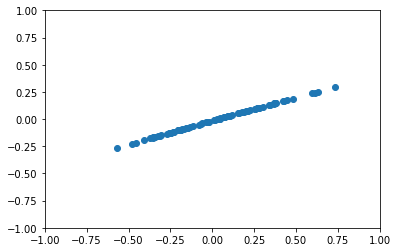

In [401]:
dec_bound = L[inter]
ball_dec = hyperboloid_pts_to_poincare(dec_bound)
%matplotlib inline
plt.scatter(ball_dec[:, 0], ball_dec[:, 1])
plt.xlim([-1,1])
plt.ylim([-1,1]);

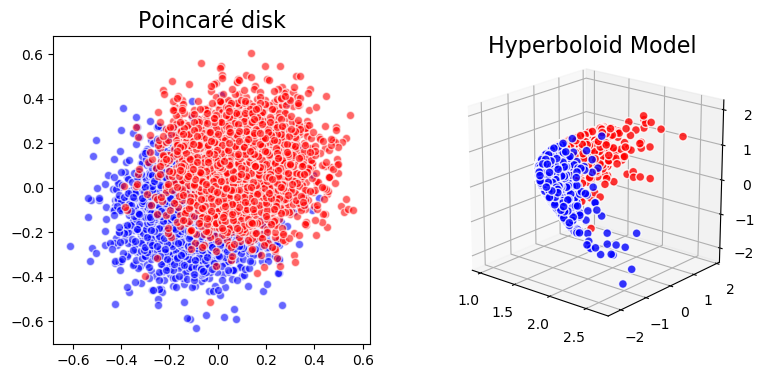

In [24]:
from sklearn.datasets import make_blobs
plt.style.use('default')
centers = [[-0.1,-0.1], [0.1, 0.1]]
X, labels = make_blobs(n_samples=5000, centers=centers, cluster_std=0.15)
data = X
mink_pts = poincare_pts_to_hyperboloid(data)
x = data[:, 0]
y = data[:, 1]

fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121)
ax.set_title('Poincaré disk', size=16)
ax.scatter(X[labels==0,0], X[labels==0,1], c='blue', alpha=0.6, edgecolors='w')
ax.scatter(X[labels==1,0], X[labels==1,1], c='red', alpha=0.6, edgecolors='w')
ax = fig.add_subplot(122, projection = '3d')
ax.scatter(mink_pts[labels==0, 0], mink_pts[labels==0, 1], mink_pts[labels==0, 2], c='blue', 
           alpha=0.8, s=40, edgecolor='white', linewidth=1)
ax.scatter(mink_pts[labels==1, 0], mink_pts[labels==1, 1], mink_pts[labels==1, 2], c='red', 
           alpha=0.8, s=40, edgecolor='white', linewidth=1)
ax.set_title('Hyperboloid Model', size=16);
ax.view_init(20, -50);
plt.show();

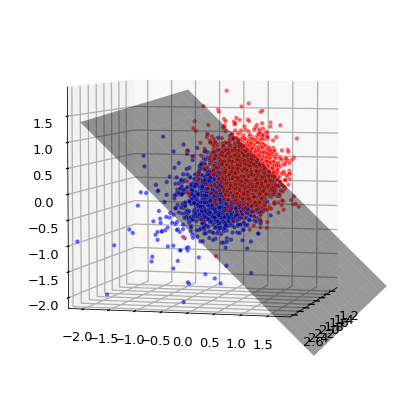

In [25]:
from sklearn.svm import LinearSVC
hsvm_clf = LinearHSVM(early_stopping=1, C=0.1, num_epochs=20, lr=0.00001, verbose=False)
hsvm_clf.fit(mink_pts, labels)
hsvm_clf.coef_
plt.style.use('seaborn-talk')
X = mink_pts
z = lambda x,y: (-hsvm_clf.coef_[0]*x-hsvm_clf.coef_[1]*y) / hsvm_clf.coef_[2]
x_range = np.linspace(0, 3, 20)
y_range = np.linspace(-1.8, 2.5, 20)
x,y = np.meshgrid(x_range, y_range)

%matplotlib inline
import matplotlib

fig = plt.figure(figsize=(7,7))
ax  = fig.add_subplot(111, projection='3d')
ax.set_xlim([np.min(X, axis=0)[0], np.max(X, axis=0)[0]])
ax.set_ylim([np.min(X, axis=0)[1], np.max(X, axis=0)[1]])
ax.set_zlim([np.min(X, axis=0)[2], np.max(X, axis=0)[2]])
ax.plot_surface(x, y, z(x,y), color='k', alpha=0.4, rstride=2, cstride=2, linewidth=.1)
ax.scatter(X[labels==0,0], X[labels==0,1], X[labels==0,2], c='blue', alpha=0.6, edgecolors='w')
ax.scatter(X[labels==1,0], X[labels==1,1], X[labels==1,2], c='red', alpha=0.6, edgecolors='w')
ax.view_init(5, 15);
plt.show();

In [ ]:
centers = [[-0.4,-0.4], [-0.1, 0.3]]
X, labels = make_blobs(n_samples=5000, centers=centers, cluster_std=0.1)
svm = LinearSVC()
svm.fit(X, labels)
svm.classes_
svm.intercept_
svm.coef_
w1 = svm.coef_[0][0]
w2 = svm.coef_[0][1]
b = svm.intercept_
x = X[0]
w1*x[0] + w2*x[1] + b

svm.predict(X)[:5]
svm.decision_function(X)[:5]
mink_pts = poincare_pts_to_hyperboloid(X)
hsvm_clf = LinearHSVM(early_stopping=1, C=1, num_epochs=15, lr=0.0001, verbose=False)
hsvm_clf.fit(mink_pts, labels)
#hsvm_clf.coef_[0] = -hsvm_clf.coef_[0]
#w[0] = -w[0]

svm.predict(X)[:5]
svm.decision_function(X)[:5]
mink_pts = poincare_pts_to_hyperboloid(X)
hsvm_clf = LinearHSVM(early_stopping=1, C=1, num_epochs=30, lr=0.01, verbose=False)
hsvm_clf.fit(mink_pts, labels)
w = hsvm_clf.coef_
#w[0] = -w[0]
np.array([minkowski_dot(w, x) for x in mink_pts[:5]])
hsvm_clf.predict(mink_pts)[:10]

svm.predict(X)[:10]
np.sum(hsvm_clf.predict(mink_pts) == svm.predict(X)) / len(labels)
np.sum(svm.predict(X) == labels) / len(labels)
np.sum(hsvm_clf.predict(mink_pts) == labels) / len(labels)